In [2]:
import os
import gc
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(rc={'figure.figsize': (16, 9)})

pd.options.mode.chained_assignment = None

In [4]:
PATH_TO_DATA = 'data/raw'

In [3]:
test = pd.read_csv(os.path.join(PATH_TO_DATA, 'example_test.csv'), index_col='row_id')
lectures = pd.read_csv(os.path.join(PATH_TO_DATA, 'lectures.csv'))

dtypes = {
    'question_id': 'int16',
    'part': 'int8'
}
questions = pd.read_csv(os.path.join(PATH_TO_DATA, 'questions.csv'), dtype=dtypes)

train_dtypes = {
    'user_id': 'int32', 
    'content_id': 'int16', 
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool'
}
train = pd.read_feather(os.path.join(PATH_TO_DATA, 'train.feather'))

user_tag_agg = pd.read_feather(os.path.join(PATH_TO_DATA, 'user_tag_agg.feather'))
train_q_tags = pd.read_feather(os.path.join(PATH_TO_DATA, 'train_q_tags.feather'))

_Конвертация большого csv в формат feather_

In [4]:
# %%time

# Подготовка feather файла для тренировачных данных
# dtypes = {
#     "row_id": "int64",
#     "timestamp": "int64",
#     "user_id": "int32",
#     "content_id": "int16",
#     "content_type_id": "boolean",
#     "task_container_id": "int16",
#     "user_answer": "int8",
#     "answered_correctly": "int8",
#     "prior_question_elapsed_time": "float32", 
#     "prior_question_had_explanation": "boolean"
# }
# df_train = pd.read_csv(os.path.join(PATH_TO_DATA, 'train.csv'), dtype=dtypes, index_col='row_id')
# df_train.reset_index(drop=True).to_feather(os.path.join(PATH_TO_DATA, 'train.feather'))

In [5]:
# %%time

# Подготовка данных по тегам для пользователей
# tags = train_q[['user_id', 'tags', 'answered_correctly']]
# tags['tags'] = tags['tags'].str.split()
# tags = tags.explode('tags')
# user_tag_agg = tags.groupby(by=['user_id', 'tags'])['answered_correctly'].agg(['sum', 'count'])
# user_tag_agg.reset_index().to_feather(os.path.join(PATH_TO_DATA, 'user_tag_agg.feather'))

## Исследование фичей train

In [6]:
train.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,False,1,3,1,NaN,<NA>
1,56943,115,5716,False,2,2,1,37000.0,False
2,118363,115,128,False,0,0,1,55000.0,False
3,131167,115,7860,False,3,0,1,19000.0,False
4,137965,115,7922,False,4,1,1,11000.0,False


In [7]:
# количестов объектов и фичей
train.shape

(101230332, 9)

In [8]:
# поля prior_question_elapsed_time и prior_question_had_explanation имеют NULL значения
train.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 9 columns):
 #   Column                          Non-Null Count      Dtype  
---  ------                          --------------      -----  
 0   timestamp                       101230332 non-null  int64  
 1   user_id                         101230332 non-null  int32  
 2   content_id                      101230332 non-null  int16  
 3   content_type_id                 101230332 non-null  boolean
 4   task_container_id               101230332 non-null  int16  
 5   user_answer                     101230332 non-null  int8   
 6   answered_correctly              101230332 non-null  int8   
 7   prior_question_elapsed_time     98878794 non-null   float32
 8   prior_question_had_explanation  100837826 non-null  boolean
dtypes: boolean(2), float32(1), int16(2), int32(1), int64(1), int8(2)
memory usage: 2.5 GB


### timestamp

Время в миллисекундах между этим взаимодействием с пользователем (этой строкой в датасете) и первым завершенным событие от этого пользователя.

In [9]:
# Максимальная разница во времени между первым и последним взаимодействием пользователя с платформой
train['timestamp'].max()

87425772049

In [10]:
# В месяцах
train['timestamp_month'] = round(train['timestamp'] / 2.628e+9).astype(int)

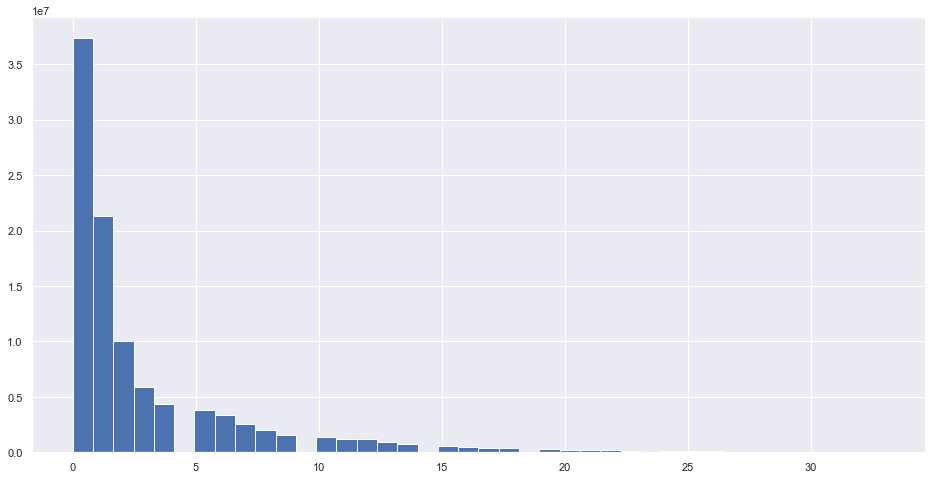

In [11]:
# Большинство пользователей недавно на платформе

plt.figure(figsize=(16, 8))
train['timestamp_month'].hist(bins=40);

In [12]:
# Для всех пользователей в датасете есть событие, которое описывает первое взаимодействие с платформой 

train['user_id'].nunique() == train[train['timestamp'] == 0]['user_id'].nunique()

True

### user_id

ID пользователя на платформе.

In [13]:
# Количество уникальных пользователей
train['user_id'].nunique()

393656

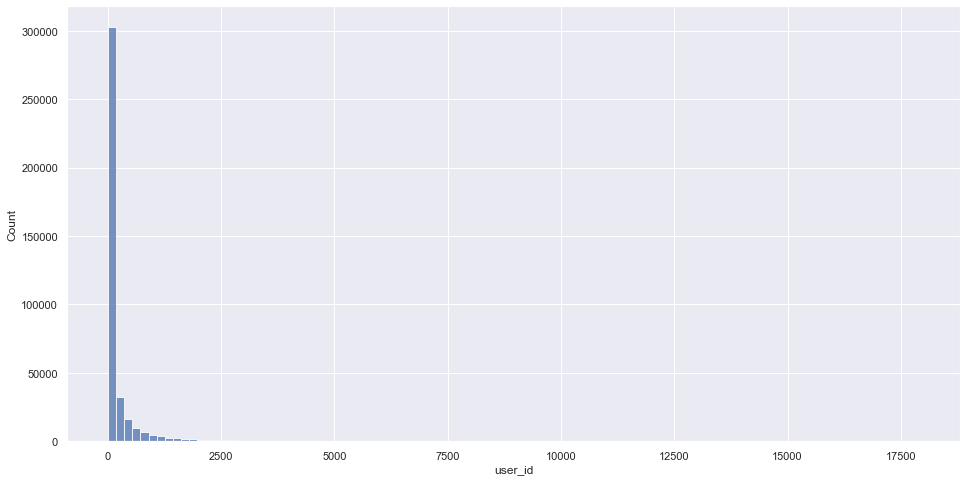

In [14]:
# Большинство пользователей совершали немного взаимодействий с платформой, но есть выбросы

fig, ax = plt.subplots(figsize=(16, 8))
sns.histplot(train['user_id'].value_counts(), bins=100, ax=ax);

### content_id, content_type_id

ID для взаимодействия пользователя с платформой:
- ID вопроса, на который отвечал пользователь, если тип взаимодействия "вопрос" (content_type_id = False)
- ID лекции, которую смотрел пользователь, если тип взаимодействия "лекция" (content_type_id = True)

In [15]:
# Количество уникальных ID взаимодействия
train['content_id'].nunique()

13782

In [16]:
# В train присуствуют все вопросы из questions
train[train['content_type_id'] == 0]['content_id'].nunique() == questions['question_id'].nunique()

True

In [17]:
# все лекции из train присутствуют в lectures
set(train[train['content_type_id'] == 1]['content_id']) - set(lectures['lecture_id'])

set()

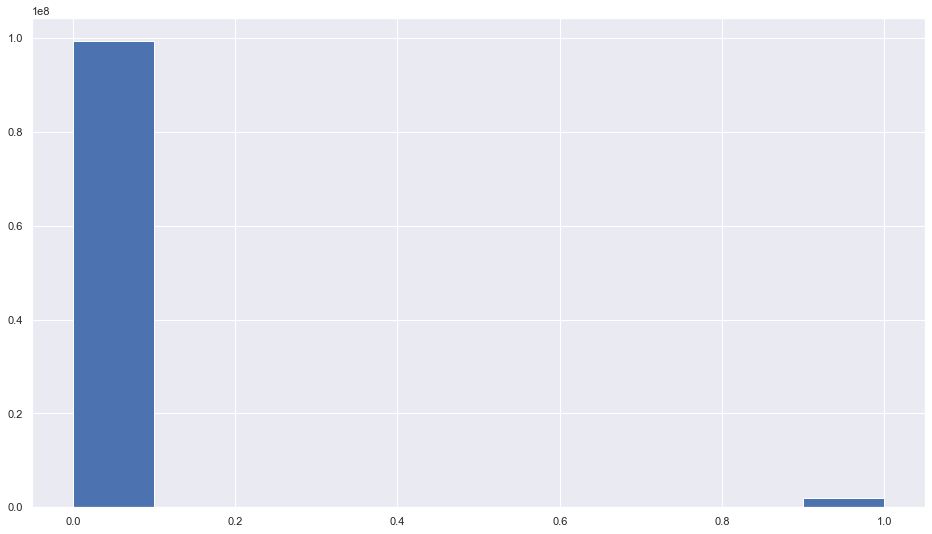

In [18]:
# в датасете преобладают вопросы
train['content_type_id'].astype(int).hist();

In [19]:
# топ-10 вопрос по всем данным
train[train['content_type_id'] == 0]['content_id'].value_counts(ascending=False)[:10]

6116    213605
6173    202106
4120    199372
175     195861
7876    190170
7900    180858
2063    176043
2064    176043
2065    176043
4492    173769
Name: content_id, dtype: int64

In [20]:
# топ-10 лекций по всем данным
train[train['content_type_id'] == 1]['content_id'].value_counts(ascending=False)[:10]

3153     37024
21411    27051
10540    24312
29695    24126
15888    22627
27845    21250
26335    21118
32312    20943
29544    20941
18545    19167
Name: content_id, dtype: int64

### task_container_id

ID пачки вопросов и лекций, которые объединены общей темой. Пользователь может ответить, например, на три вопроса, которые относятся к одному task_container_id. Лекции и вопросы находятся в разных task_container_id.

???
The API provides user interactions groups in the order in which they occurred. Each group will contain interactions from many different users, but no more than one task_container_id of questions from any single user. Each group has between 1 and 1000 users.

In [21]:
# количество групп вопрсов и лекций
train['task_container_id'].nunique()

10000

In [22]:
cont_size = train.groupby(by=['task_container_id']).size()

In [23]:
# группы с маленькими индексами встречаются гораздо чаще (вводные курсы/вопросы?)
cont_size[:30]

task_container_id
0     395990
1     395934
2     395595
3     395341
4     692079
5     690051
6     688813
7     684275
8     400019
9     399641
10    400660
11    403521
12    393358
13    388645
14    804285
15    798539
16    327490
17    308415
18    298483
19    292249
20    284771
21    275403
22    272569
23    269563
24    268550
25    267958
26    256507
27    248244
28    243847
29    239636
dtype: int64

In [ ]:
# Для ответов на вопросы в рамках одного task_container_id будут одинаковые даты.

### user_answer

Каким значением пользоваель ответил на вопрос. Для лекции поле принимает заначение -1, для вопросов 0-3.

In [24]:
# соотношение user_answer в данных
train['user_answer'].value_counts()

 0    28186489
 1    26990007
 3    26084784
 2    18010020
-1     1959032
Name: user_answer, dtype: int64

In [25]:
# для вопросов -1 не используется 
len(train[(train['user_answer'] == -1) & (train['content_type_id'] == False)])

0

### prior_question_elapsed_time

Среднее время в миллисекундах, которое потребовалось пользователю, чтобы ответить на каждый вопрос в предыдущей группе вопросов. Лекции не учитываются.
Это _среднее время_, затраченное пользователем на решение _каждого_ вопроса из предыдущего пакета.
Для первой группы вопросов значение не определено. 

### prior_question_had_explanation

Видел ли пользователь объяснение и правильный ответ на предыдущий набор вопросов.

### answered_correctly

Правильно ли пользователь ответил на вопрос: 1 - верно, 0 - неверно.

Для лекций используется -1.

In [26]:
# соотношение правильных и неверных ответов
train['answered_correctly'].value_counts()

 1    65244627
 0    34026673
-1     1959032
Name: answered_correctly, dtype: int64

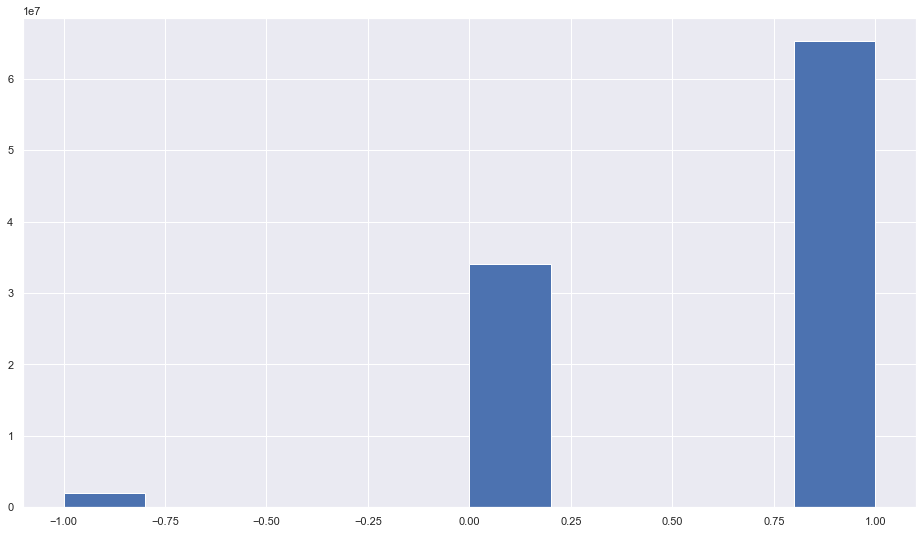

In [27]:
train['answered_correctly'].hist();

## Исследование фичей questions

In [28]:
questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [29]:
questions.dtypes

question_id        int16
bundle_id          int64
correct_answer     int64
part                int8
tags              object
dtype: object

### part

ID раздела, к которому относиться вопрос.

In [30]:
# количестов уникальных разделов
questions['part'].unique()

array([1, 2, 3, 4, 5, 6, 7], dtype=int8)

In [31]:
questions['part'].value_counts().to_frame()

,part
5,5511
2,1647
3,1562
4,1439
6,1212
7,1160
1,992


### tags

ID тега. Тег кластеризуют вопросы по темам (вероятно).
Каждый вопрос имеет как минимум один тег.

In [32]:
# Количество уникальных тегов
questions['tags'].str.split().explode('tags').nunique()

188

## EDA

In [33]:
# трейн только для вопросов
train_q = train[train['content_type_id'] == False]

In [34]:
del train
gc.collect()

12607

In [35]:
# Оставить только последнии 24 взаимодействия пользователя с платформой 
train_q = train_q.groupby('user_id').tail(24).reset_index(drop=True)

In [36]:
# объеденим трейн с вопросами
train_q = pd.merge(
    train_q,
    questions,
    left_on='content_id',
    right_on='question_id',
    how='left'
)
train_q.drop(columns=['question_id'], inplace=True)

In [37]:
# фичи на основе тегов вопроса
train_q['user_tags_correctness'] = train_q_tags['user_tags_correctness']
train_q['tags_total_answer'] = train_q_tags['tags_total_answer']
train_q['best_tag_correctness'] = train_q_tags['best_tag_right'] / train_q_tags['best_tag_answers']

In [38]:
del train_q_tags
gc.collect()

60

In [39]:
# Общая правильность пользователей
user_agg = train_q.groupby('user_id')['answered_correctly'].agg(['sum', 'count'])

# Общая сложность вопросов
content_agg = train_q.groupby('content_id')['answered_correctly'].agg(['sum', 'count'])

In [40]:
# таргет имеет небольшую корреляцию с prior_question_had_explanation
train_q['prior_question_had_explanation'].astype(float).corr(train_q['answered_correctly'])

0.20127416972548712

In [41]:
# ID пачки вопрсов немного коррелирует с таргетом (есть сложные пачки на которых ошибаются все?)
train_q['task_container_id'].corr(train_q['answered_correctly'])

0.06859712638895846

In [42]:
# был ли предыдущий вопрос отвечен правильно, коррелирует с таргетом
train_q['answered_correctly'].shift().corr(train_q['answered_correctly'])

0.1303798000486994

In [43]:
# правильно ли пользователь ответил на предыдущий вопрос
train_q['lag'] = train_q.groupby('user_id')['answered_correctly'].shift()

# на сколько вопрсоов ответил правильно и сколько всего было задано (изменяется по мере продвижения по датасету)
cum = train_q.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])

# правливьность ответов пользователя
train_q['user_correctness'] = cum['cumsum'] / cum['cumcount']

In [44]:
# правлиьность ответов пользователя коррелирует хорошо
train_q['user_correctness'].corr(train_q['answered_correctly'])

0.2104817315819393

In [45]:
# Сколько раз правильно ответили на вопрос все пользователи
train_q['content_count'] = train_q['content_id'].map(content_agg['count']).astype('int32')

# Хорошая обратная корреляция
train_q['content_count'].corr(train_q['answered_correctly'])

-0.19935557054820363

In [46]:
# На сколько вопрос сложный, как часто пользователи в нем ошибались
train_q['content_difficult'] = train_q['content_id'].map(content_agg['sum'] / content_agg['count'])

# Хорошая корреляция с тем как часто ошибаются остальные пользователи
train_q['content_difficult'].corr(train_q['answered_correctly'])

0.3784310969219484

In [170]:
# промежуток времени между bundle

train_q['time_between_bundle'] = train_q['timestamp'] - train_q.groupby(by=['user_id'])['timestamp'].shift(1)
train_q['time_between_bundle'] = train_q['time_between_bundle'].replace(to_replace=0, method='ffill').fillna(0)
train_q['time_between_bundle'] = train_q['time_between_bundle'].astype(int)

In [ ]:
# корреляция плохая, но скор докидывает
train_q['time_between_bundle'].corr(train_q['answered_correctly'])

In [47]:
# user_tag_agg = user_tag_agg.set_index(['user_id', 'tags'])
# def get_tags_correctness(row):
#     tags_right_answer = 0
#     tags_all_answer = 0
#     for tag in row['tags'].split():
#         tags_right_answer += user_tag_agg.loc[row['user_id'], tag]['sum']
#         tags_all_answer += user_tag_agg.loc[row['user_id'], tag]['count']
#     return tags_right_answer / tags_all_answer

In [48]:
# %%time

# train_q['user_tags_correctness'] = train_q.apply(get_tags_correctness, axis=1)

In [49]:
# train_q['user_tags_correctness'].corr(train_q['answered_correctly'])

In [5]:
train_dtypes = {
    'user_id': 'int32', 
    'content_id': 'int16', 
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool'
}
train = pd.read_feather(os.path.join(PATH_TO_DATA, 'train.feather'))

In [6]:
train = train[train['answered_correctly'] != -1].reset_index(drop=True)

In [7]:
train = train[1200*10000: 2*1200*10000]

In [9]:
dtypes = {
    'question_id': 'int16',
    'part': 'int8'
}
questions = pd.read_csv(os.path.join(PATH_TO_DATA, 'questions.csv'), dtype=dtypes)

In [10]:
train = pd.merge(
    train,
    questions,
    left_on='content_id',
    right_on='question_id',
    how='left'
)
train.drop(columns=['question_id'], inplace=True)

In [17]:
def add_tags_feature(row):
    tags_right_answer = 0
    tags_all_answer = 0
    best_tag = {}
    for tag in row['tags'].split():
        tag = int(tag)
        tag_right_answer = 0
        tag_all_answer = 0
        if row['user_id'] in USER_TAGS:
            if tag in USER_TAGS[row['user_id']]:
                tag_right_answer = USER_TAGS[row['user_id']][tag]['right_answer']
                tag_all_answer = USER_TAGS[row['user_id']][tag]['all_answer']
                USER_TAGS[row['user_id']][tag]['right_answer'] += row['answered_correctly']
                USER_TAGS[row['user_id']][tag]['all_answer'] += 1
            else:
                USER_TAGS[row['user_id']][tag] = {
                    'right_answer': row['answered_correctly'],
                    'all_answer': 1
                }
        else:
            USER_TAGS[row['user_id']] = {
                tag: {
                    'right_answer': row['answered_correctly'],
                    'all_answer': 1
                }
            }
        tags_right_answer += tag_right_answer
        tags_all_answer += tag_all_answer
        if tag_all_answer:
            tag_score = tag_right_answer / tag_all_answer
        else:
            tag_score = 0

        if best_tag:
            score = best_tag['score']
            if score < tag_score:
                best_tag = {
                    'id': tag,
                    'score': tag_score,
                    'right_answer': tag_right_answer,
                    'all_answer': tag_all_answer
                }
        else:
            best_tag = {
                'id': tag,
                'score': tag_score,
                'right_answer': tag_right_answer,
                'all_answer': tag_all_answer
            }

    if not tags_all_answer:
        row['user_tags_correctness'] = None
        row['tags_total_answer'] = None
    else:
        row['user_tags_correctness'] = tags_right_answer / tags_all_answer
        row['tags_total_answer'] = tags_all_answer

    row['best_tag'] = best_tag['id'] if best_tag else None
    row['best_tag_right'] = best_tag['right_answer'] if best_tag else None
    row['best_tag_answers'] = best_tag['all_answer'] if best_tag else None
    
    return row

In [18]:
%%time

USER_TAGS = {}
train = train.apply(add_tags_feature, axis='columns')

CPU times: user 7h 47min 59s, sys: 15min 20s, total: 8h 3min 19s
Wall time: 8h 13min 30s


In [21]:
train[['user_tags_correctness', 'tags_total_answer', 'best_tag', 'best_tag_right', 
         'best_tag_answers']].to_csv(os.path.join(PATH_TO_DATA, 'best_tag.csv'))

In [29]:
import pickle

with open(os.path.join(PATH_TO_DATA, 'user_tags.dict'), 'wb') as f:
    pickle.dump(USER_TAGS, f)

In [79]:
# USER_TAGS

In [224]:
user = train_q[train_q['user_id'] == 115]

In [37]:
user_tag_agg = pd.read_feather(os.path.join(PATH_TO_DATA, 'user_tag_agg.feather'))

In [42]:
tags_agg = user_tag_agg.groupby('tags')['sum'].sum() / user_tag_agg.groupby('tags')['count'].sum()

In [81]:
tags_agg.loc

tags
0      0.626474
1      0.608267
10     0.662076
100    0.704964
101    0.788714
         ...   
95     0.695039
96     0.620850
97     0.660286
98     0.725224
99     0.740721
Length: 188, dtype: float64

In [69]:
def get_tags_corr(tags):
    result = 0
    tags = tags.split()
    for tag in tags:
        result += tags_agg.loc[tag]
    return result / len(tags)

In [78]:
%%time

train['tags'].apply(get_tags_corr)

CPU times: user 4min 55s, sys: 2.74 s, total: 4min 58s
Wall time: 5min 4s


0           0.763548
1           0.752740
2           0.659576
3           0.750310
4           0.779666
              ...   
11999995    0.702609
11999996    0.686426
11999997    0.693864
11999998    0.693650
11999999    0.708070
Name: tags, Length: 12000000, dtype: float64

### Проверить

- слушал ли студент лекцию перед вопросами?
- user_part_correctness
- number_lectures_attended, percent_of_tags_with_lectures, 


### Процесс сабмита

Либа riiideducation предоставляет итератор, который за раз возвращает инфу по взаимодействиям с платформой для 1-1000 пользователей.
